<a href="https://colab.research.google.com/github/DuyCao3108/tweet/blob/main/Tweet_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PREPROCESSING

In [6]:
df = pd.read_csv(r'/content/train.csv')

In [7]:
# Download stopwords and punkt if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and convert to lowercase
    table = str.maketrans('', '', string.punctuation)
    tokens = [word.translate(table).lower() for word in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoin the tokens to form cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Use clean_text function on every sentence in text column
df.text = df.text.apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# LSTM

In [ ]:
model = tf.keras.Sequential([
    input = tf.keras.Input(shape=()),
    Embed = tf.keras.layers.Embedding()
])

# BERT

In [3]:
# !git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git
# !pip install -Uqr models/official/requirements.txt

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
# these functions are used to get desired input format for Bert
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import pandas as pd
import os
import nltk
import string
# these functions are used for text cleaning
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv(r'/content/train.csv')

## Input preparation for Bert layer

In [53]:
train_df, valid_df = train_test_split(df, test_size = 0.10)

In [54]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.text.values,train_df.target.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values,valid_df.target.values))

In [44]:
label_list = [0,1]
max_seq_length = 50
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable = False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file = vocab_file, do_lower_case = do_lower_case)

In [43]:
# This provides a function to convert row to input features and label
def to_feature(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer= tokenizer):
    example = classifier_data_lib.InputExample(
        guid = None,
        text_a = text.numpy(),
        text_b =None,
        label = label.numpy()
    )
    feature = classifier_data_lib.convert_single_example(
        0,
        example,
        label_list,
        max_seq_length,
        tokenizer
    )
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


In [45]:
def to_feature_map(text, label):

    input_ids, input_mask, segment_ids, label_id = tf.py_function(
        to_feature,
        inp = [text,label],
        Tout = [tf.int32,tf.int32, tf.int32, tf.int32 ]
    )

    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        "input_mask": input_mask,
        "input_type_ids": segment_ids
    }

    return (x, label_id)


In [14]:
# train
train_data = (
    train_data.map(to_feature_map,
                   num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .shuffle(1000)
    .batch(32,drop_remainder = True)
    .prefetch(tf.data.experimental.AUTOTUNE)
  )

# valid
valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
.batch(32, drop_remainder = True)
.prefetch(tf.data.experimental.AUTOTUNE)
)

## Building model

In [15]:
def get_model():
    # define input
    input_word_ids = tf.keras.layers.Input(shape =(max_seq_length,),dtype = tf.int32,
                                           name='input_word_ids')
    input_mask = tf.keras.layers.Input(shape =(max_seq_length,),dtype = tf.int32,
                                           name='input_mask')
    input_type_ids = tf.keras.layers.Input(shape =(max_seq_length,),dtype = tf.int32,
                                           name='input_type_ids')
    # pass input through bert layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    # use pooled output to pass through some dense layers
    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    dense_1 = tf.keras.layers.Dense(units = 200)(drop)
    dense_2 = tf.keras.layers.Dense(units = 100)(dense_1)
    dense_3 = tf.keras.layers.Dense(units = 20)(dense_2)
    # last layer will has sigmoid activation
    output = tf.keras.layers.Dense(1,activation = 'sigmoid', name = "output")(dense_3)
    # define model
    model = tf.keras.Model(
        inputs ={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs = output
    )
    # create check point to save model
    checkpoint_path = os.path.join(os.getcwd(), "cp.ckpt")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True, verbose=1
                                                    )
    return model, cp_callback

In [16]:
model, cp_callback = get_model()
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 50, 768)]                 'input_mask[0][0]',         

In [17]:
epochs = 4
his = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = epochs,
    verbose = 1,
    callbacks= [cp_callback]
)

Epoch 1/4
214/214 [==============================] - ETA: 0s - loss: 0.6637 - binary_accuracy: 0.6416
Epoch 1: saving model to /content/cp.ckpt
214/214 [==============================] - 46s 138ms/step - loss: 0.6637 - binary_accuracy: 0.6416 - val_loss: 0.6170 - val_binary_accuracy: 0.6481
Epoch 2/4
214/214 [==============================] - ETA: 0s - loss: 0.5901 - binary_accuracy: 0.6957
Epoch 2: saving model to /content/cp.ckpt
214/214 [==============================] - 30s 133ms/step - loss: 0.5901 - binary_accuracy: 0.6957 - val_loss: 0.5158 - val_binary_accuracy: 0.7731
Epoch 3/4
214/214 [==============================] - ETA: 0s - loss: 0.5824 - binary_accuracy: 0.7093
Epoch 3: saving model to /content/cp.ckpt
214/214 [==============================] - 31s 142ms/step - loss: 0.5824 - binary_accuracy: 0.7093 - val_loss: 0.5312 - val_binary_accuracy: 0.7364
Epoch 4/4
214/214 [==============================] - ETA: 0s - loss: 0.5791 - binary_accuracy: 0.7135
Epoch 4: saving model 

### Evaluate

In [32]:
def convert_single_string_to_input_dict(example_string_prep, vocab_file_path, max_seq_length):

  #Inizialize BERT tokenizer
  tokenizer = tokenization.FullTokenizer(vocab_file_path, do_lower_case=True)
  token_a = tokenizer.tokenize(example_string_prep)

  tokens = []
  segments_ids = []
  segment_ids = []

  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in token_a:
    tokens.append(token)
    segment_ids.append(0)

  tokens.append('[SEP]')
  segment_ids.append(0)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_mask = [1] * len(input_ids)

  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  label_id = [0]
  padding = [0] * max_seq_length

  print(len(input_ids),len(input_mask),len(segment_ids),len(label_id))

  return {"input_ids":[input_ids,padding], "input_mask":[input_mask,padding], "segment_ids":[segment_ids,padding], "label_ids":label_id}

In [49]:
test_df = pd.read_csv(r'/content/test.csv')

In [55]:
valid_df

,id,keyword,location,text,target
7192,10304,weapon,MI - CA,iranian warship points weapon us helicopter of...,1
1717,2478,collided,NaN,2 cars right front collided hadnt stopped time...,1
22,33,NaN,NaN,love skiing,0
4820,6861,mass%20murder,i'm a Citizen of the World,abortion murder blowjobs cannibalism masturbat...,1
4601,6543,injury,"Sacramento, CA",traffic collision injury i5 i5 43rd ave offr...,1
...,...,...,...,...,...
3235,4644,emergency%20services,"Park Ridge, Illinois",doctors nurses new pediatric emergency departm...,0
1056,1525,body%20bags,NaN,zicac vintage leather briefcase messenger satc...,0
3850,5479,flames,hell,gilderoy wish good enough add flames nails im...,1
4510,6410,hurricane,Somewhere Powerbraking A Chevy,freegeezy17 stay houston,0


In [69]:
# Load test data (assuming you have a test DataFrame called test_df)
test_data = tf.data.Dataset.from_tensor_slices(valid_df['text'].values)

# Preprocess the test data
def preprocess_test_data(text):
    input_ids, input_mask, segment_ids, _ = tf.py_function(
        to_feature,
        inp=[text, 0],  # Use a dummy label of 0, as labels are not available
        Tout=[tf.int32, tf.int32, tf.int32, tf.int32]
    )

    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])

    x = {
        'input_word_ids': input_ids,
        "input_mask": input_mask,
        "input_type_ids": segment_ids
    }

    return x

# Preprocess the test data
test_data = (
    test_data.map(preprocess_test_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Make predictions on the test data
predictions = model.predict(test_data)

# 'predictions' now contains the predicted probabilities for each test example


24/24 [==============================] - 2s 106ms/step


In [57]:
from sklearn.metrics import confusion_matrix

In [70]:
def label(x):
      if x > 0.5: return 1
      else: return 0
predict_labels = np.array([label(p) for p in predictions])
actual_labels = valid_df.target.values

In [71]:
confusion_matrix(actual_labels,predict_labels)

array([[375,  67],
       [120, 200]])

In [72]:
import seaborn

<Axes: >

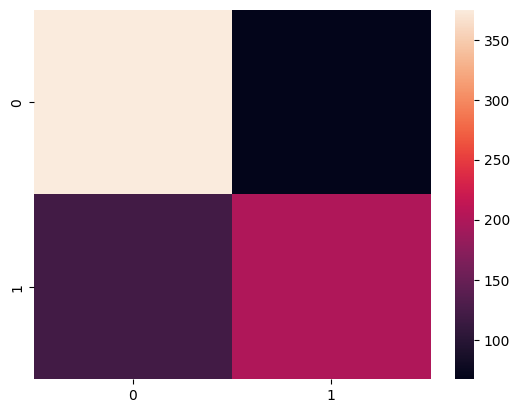

In [73]:
seaborn.heatmap(confusion_matrix(actual_labels,predict_labels))

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(actual_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)

    # Calculate accuracy
    accuracy = accuracy_score(actual_labels, predicted_labels)

    # Calculate precision
    precision = precision_score(actual_labels, predicted_labels)

    # Calculate recall
    recall = recall_score(actual_labels, predicted_labels)

    # Calculate F1-score
    f1 = f1_score(actual_labels, predicted_labels)

    # Create a dictionary to store the metrics
    metrics = {
        "Confusion_Matrix": cm,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    return metrics

metrics = calculate_metrics(actual_labels, predict_labels)
print(metrics)


{'Confusion_Matrix': array([[375,  67],
       [120, 200]]), 'Accuracy': 0.7545931758530183, 'Precision': 0.7490636704119851, 'Recall': 0.625, 'F1-Score': 0.6814310051107325}
